# Airbnb Las Vegas Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel


from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from scipy.special import softmax

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [69]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
  return (X_res, y_res)

# EDA Analysis

In [26]:
df = pd.read_csv("/Users/maukanmir/Downloads/las_vegas_airbnb_data.csv")
df

,roomType,stars,address,numberOfGuests,primaryHost/smartName,price,firstReviewComments,firstReviewRating
0,Entire condo,4.54,"Las Vegas, Nevada, United States",4,Doug,NaN,"Overall, I had a good experience. The only dow...",4.0
1,Entire rental unit,4.39,"Las Vegas, Nevada, United States",4,Doug,NaN,I stayed an extra night. That should sum it up...,5.0
2,Entire guest suite,NaN,"Las Vegas, Nevada, United States",4,Aaron&Tina,NaN,These days things are so impersonable but she ...,5.0
3,Entire condo,NaN,"Las Vegas, Nevada, United States",6,Aaron&Tina,NaN,Great response time from owner. Could message ...,5.0
4,Private room in home,4.51,"Las Vegas, Nevada, United States",2,Brad,NaN,good group of guys in the house. quiet clean a...,5.0
...,...,...,...,...,...,...,...,...
995,Entire condo,5.00,"Las Vegas, Nevada, United States",4,Rich,NaN,First time doing a long term rental. The bar w...,5.0
996,Entire home,4.77,"Henderson, Nevada, United States",7,Hostit,NaN,"This is my 2nd time staying here, great house,...",5.0
997,Entire condo,4.93,"Lake Las Vegas, Henderson, Nevada, United States",2,Cece,NaN,Really nice little studio! I spent a month her...,5.0
998,Entire home,5.00,"Las Vegas, Nevada, United States",8,Kun,NaN,"A stunning house, it was a pleasure to stay th...",5.0


# Check for Nulls and Dupes

In [27]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: roomType                    0
stars                     277
address                     0
numberOfGuests              0
primaryHost/smartName       0
price                    1000
firstReviewComments       205
firstReviewRating         205
dtype: int64
Dupe Count: 157


In [28]:
df.drop([col for col in df.columns if col not in ['firstReviewComments', 'firstReviewRating']], inplace=True, axis=1)

In [34]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [35]:
df.shape

(791, 2)

In [36]:
df

,firstReviewComments,firstReviewRating
0,"Overall, I had a good experience. The only dow...",4.0
1,I stayed an extra night. That should sum it up...,5.0
2,These days things are so impersonable but she ...,5.0
3,Great response time from owner. Could message ...,5.0
4,good group of guys in the house. quiet clean a...,5.0
...,...,...
994,Great value and walking distance to MGM and st...,5.0
995,First time doing a long term rental. The bar w...,5.0
996,"This is my 2nd time staying here, great house,...",5.0
997,Really nice little studio! I spent a month her...,5.0


# Change Column Names

In [41]:
df.columns = ["review", "rating"]

# Check For Class Imbalance

Class=4.0, Count=67, Percentage=8.470%
Class=5.0, Count=692, Percentage=87.484%
Class=1.0, Count=13, Percentage=1.643%
Class=3.0, Count=13, Percentage=1.643%
Class=2.0, Count=6, Percentage=0.759%


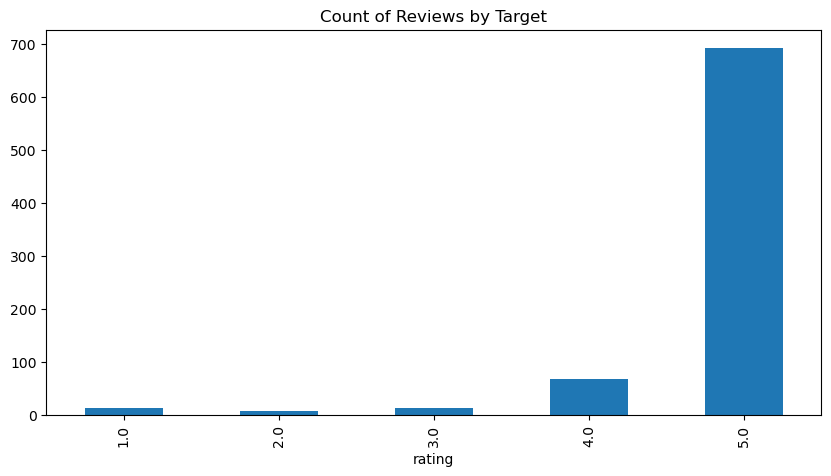

In [42]:
check_class_imbalance(df, df["rating"], "rating")

# Severe Class Imbalance

In [43]:
df['len_text'] = df['review'].apply(lambda x: len(x))
df['num_words'] = df['review'].apply(lambda x: len(x.split())) 

# Visuals

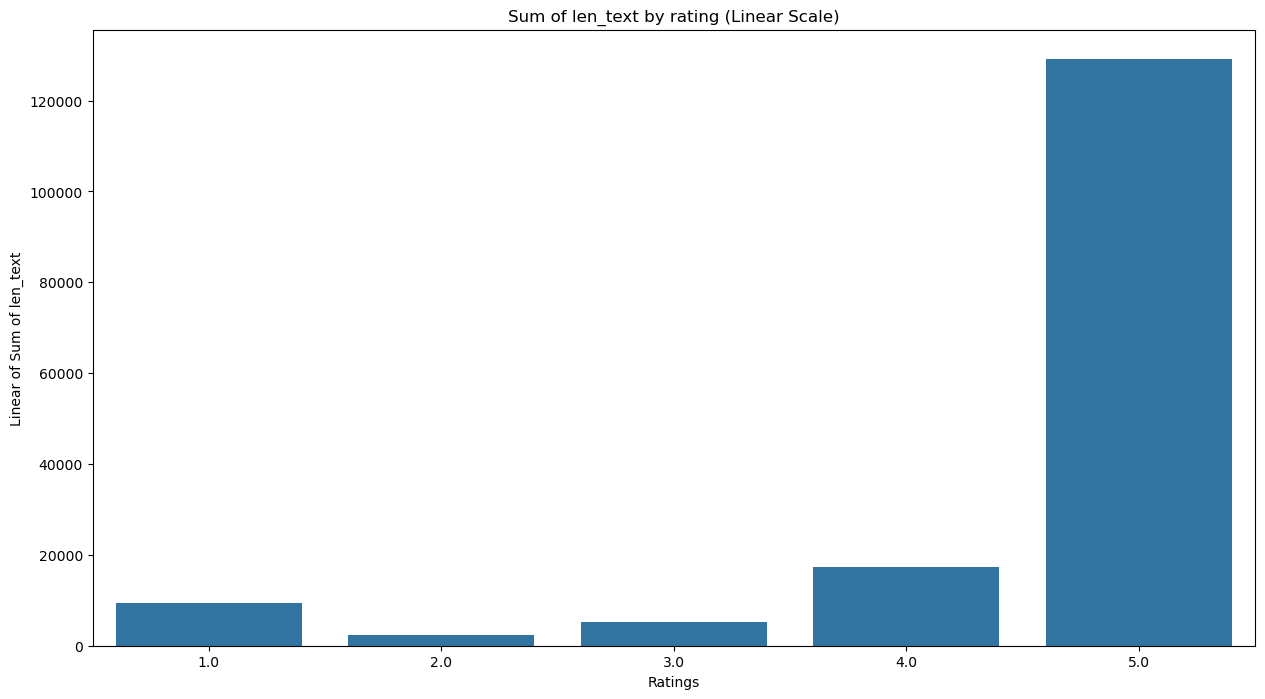

In [44]:
len_text_summary = df.groupby('rating')['len_text'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=len_text_summary, x='rating', y='len_text')
plt.yscale('linear')
plt.title('Sum of len_text by rating (Linear Scale)')
plt.xlabel('Ratings')
plt.ylabel('Linear of Sum of len_text')
plt.show()

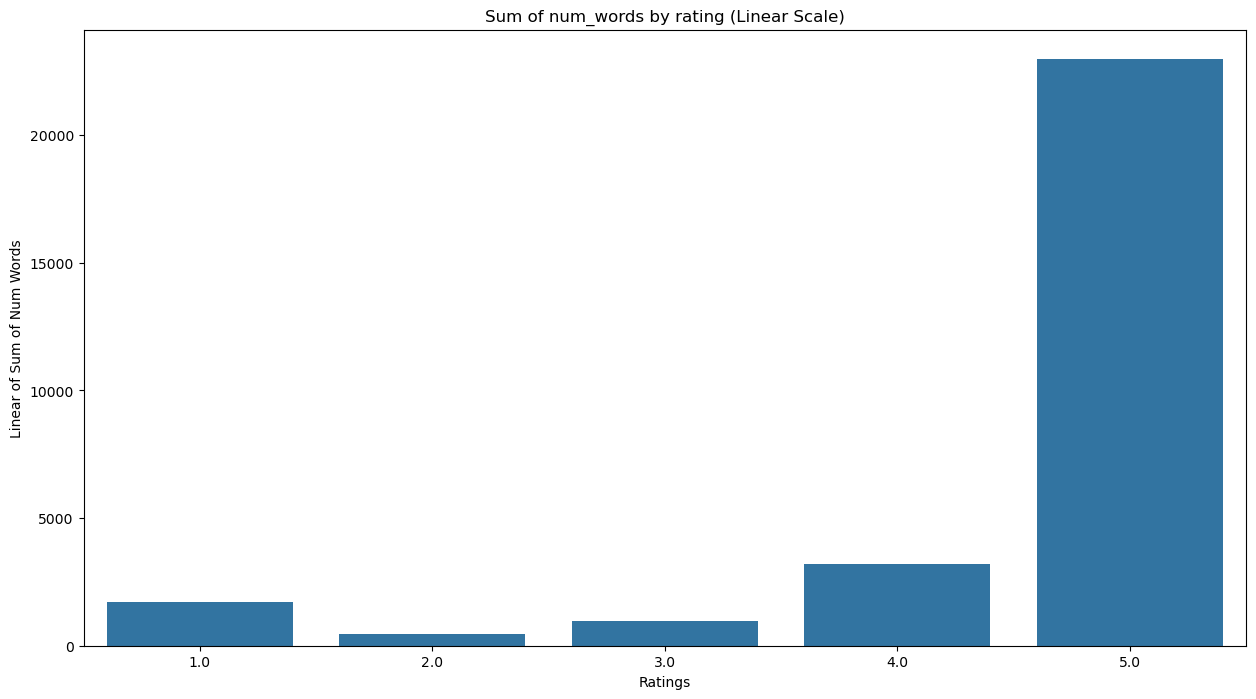

In [46]:
num_words_summary = df.groupby('rating')['num_words'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(data=num_words_summary, x='rating', y='num_words')
plt.yscale('linear')
plt.title('Sum of num_words by rating (Linear Scale)')
plt.xlabel('Ratings')
plt.ylabel('Linear of Sum of Num Words')
plt.show()

# BERT Model

In [47]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [48]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
  "roberta_neg":scores[0],
  "roberta_neu":scores[1],
  "roberta_pos":scores[2]
  }
  
  return scores_dict

In [49]:
for idx, row in df.iterrows():
  if row['rating'] in [2,3]:
    scores = polarity_scores_roberta(row['review'])

    results = scores['roberta_pos'], scores['roberta_neu'], scores['roberta_neg']
    
    max_index = results.index(max(results))
    new_rating = 5 if max_index in [0,1] else 1
    
    df.at[idx, 'rating'] = new_rating
  

In [50]:
df["rating"] = df["rating"].apply(lambda x: 0 if x in [4,5] else 1)

# Take another look at the binary classificaiton imbalance

Class=0, Count=768, Percentage=97.092%
Class=1, Count=23, Percentage=2.908%


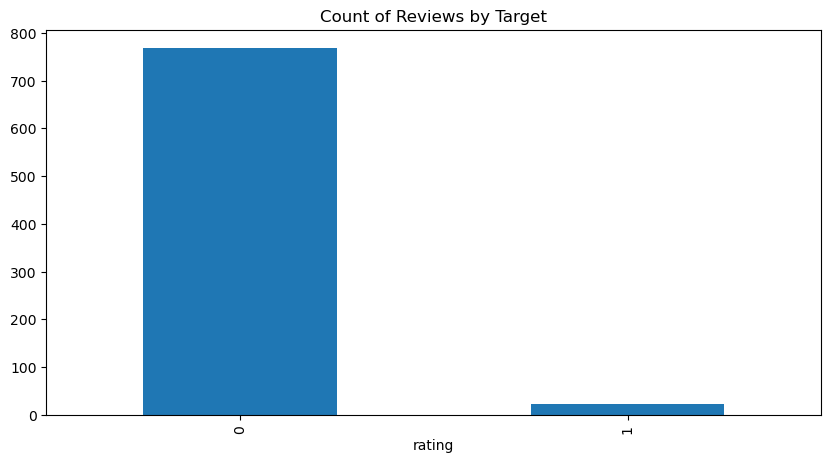

In [51]:
check_class_imbalance(df,df['rating'], 'rating')

# Severe class imbalance

# Feature Variables

In [52]:

X,y = df.drop("rating", axis=1), df['rating']

# Create Vector Embedding

In [53]:
MODEL = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

In [54]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [55]:
X['text_embeddings'] = X['review'].apply(lambda x: get_embeddings(x))

features = np.array(X['text_embeddings'].tolist()).reshape(X.shape[0], -1)

# Baseline Model

In [56]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='constant', constant=1) 

scores = evaluate_model(features, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.056 (0.006)


# Testing Model without Sampling

In [58]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,LR,0.505238,0.220986


In [61]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,SVC,0.0,0.0


In [62]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
1,XGB,0.37127,0.228678
0,RFC,0.12000,0.170750


In [63]:
names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, features, y)

,Model,Mean,STD
0,DTC,0.426668,0.260980
1,GBC,0.422011,0.225745


# Testing With Sampling Methods

# SMOTE Testing

In [70]:
X_smote, y_smote = get_over_sampling_methods(features, y, "SMOTE")

In [71]:
names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,LR,0.992465,0.002247


In [72]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,SVC,0.982119,0.005279


In [73]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.997195,0.002604
1,XGB,0.993543,0.002868


In [74]:
names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,GBC,0.994400,0.002987
0,DTC,0.983504,0.007227


# With over sampling the model seems to be overfitting

# BL SMOTE

In [75]:
X_bl_smote, y_bl_smote = get_over_sampling_methods(features, y, "BL-SMOTE")

In [76]:

names = ['LR']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
0,LR,0.993093,0.002867


In [77]:
names = ['SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
0,SVC,0.983107,0.006533


In [78]:
names = ['RFC', "XGB"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)

,Model,Mean,STD
0,RFC,0.995662,0.003886
1,XGB,0.993085,0.004405


In [79]:

names = ['DTC', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl_smote, y_bl_smote)